In [87]:
# Notebook created solely for the final report based off the prototype and presentation ones.
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter

plt.style.use("seaborn-v0_8")

# FRIENDLY NAMES:
FRIENDLY_NAMES = {
    "C": "C",
    "CXX": "C++",
    "RUST": "Safe Rust",
    "RUST_OOB": "No Out-of-Bounds",
    "RUST_RPTR": "Raw Pointers",
}

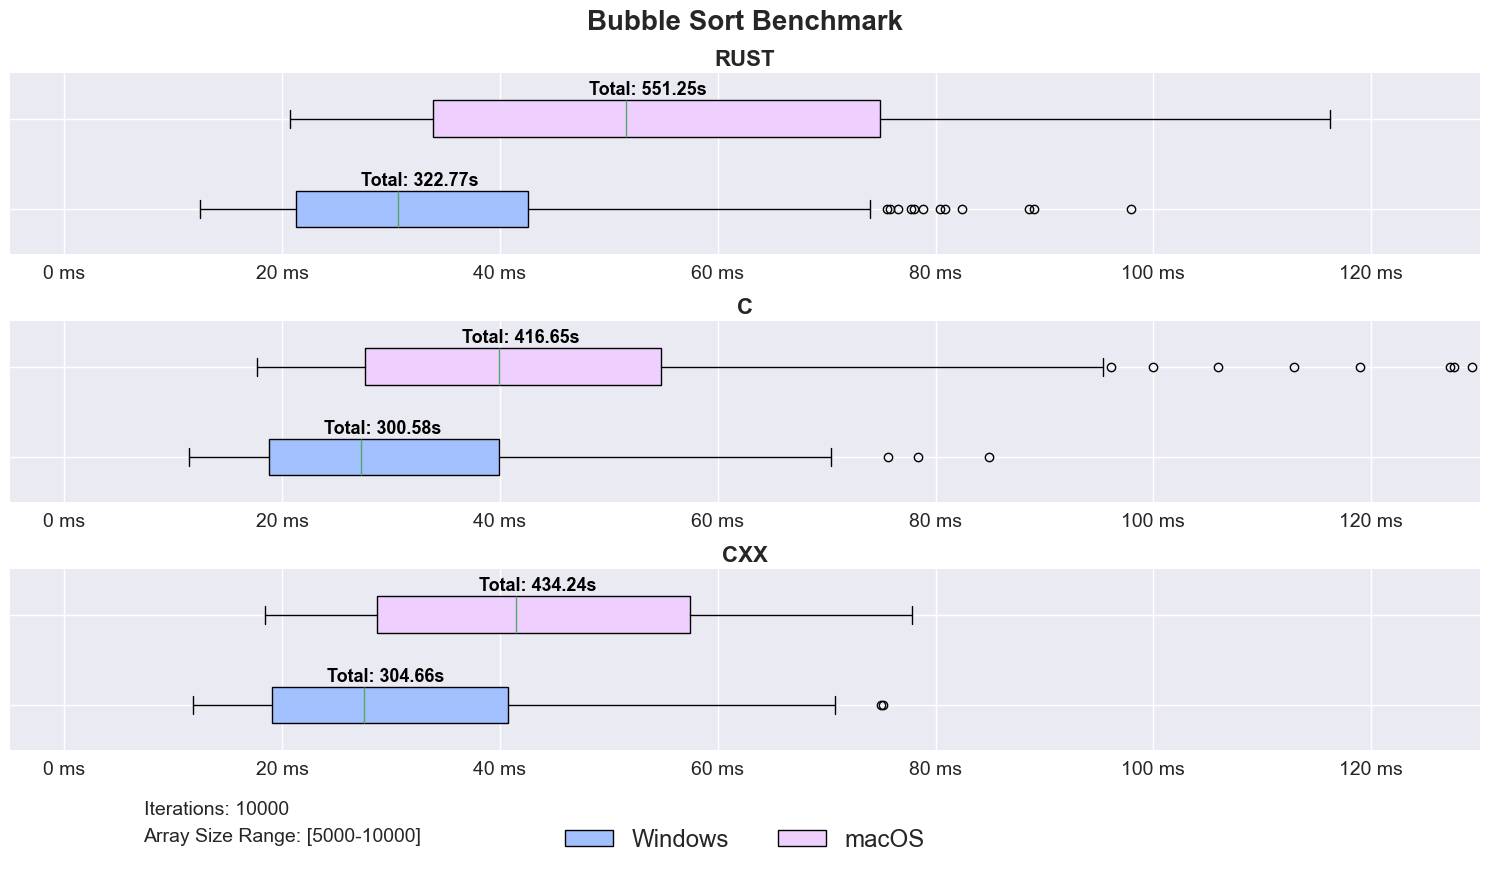

In [409]:
# GRAPH A: A Direct Benchmark Between Rust, C, and C++ (FINAL)
df_win32 = pl.read_parquet("bubble-win32.parquet").select(["RUST", "C", "CXX"])
df_osx = pl.read_parquet("bubble-darwin.parquet").select(["RUST", "C", "CXX"])


# In hindsight, the language should've been its own column to make it easier for mpl to graph.
WIN_POS_START_DELTA = [0.2, 1.0]
OSX_POS_START_DELTA = [-0.2, 1.0]
BAR_WIDTH = 0.4

def format_time(_x, pos, _ax):
    # Seconds -> MS
    _x *= 1000
    return f'{_x:.0f} ms'

fig, axes = plt.subplots(3, 1, figsize=(15, 8))
for i, (column, osx_column) in enumerate(zip(df_win32.columns, df_osx.columns)):
    ax = axes[i]
    win_plot = ax.boxplot(df_win32.select(pl.col(column)), orientation="horizontal", patch_artist=True,
               label=["" if i >= 1 else "Windows"], positions=[0], widths=[BAR_WIDTH])
    total = ax.annotate("Total: %.2fs" % (df_win32[column].sum()), xy=(df_win32[column].median() + 0.002, .27),
                        fontweight="bold", color="black", fontsize=13)
    total.set_horizontalalignment("center")
    
    for box in win_plot["boxes"]:
        box.set_facecolor("xkcd:pastel blue")

    osx_plot = ax.boxplot(df_osx.select(pl.col(column)), orientation="horizontal", patch_artist=True,
                label=["" if i >= 1 else "macOS"], positions=[1], widths=[BAR_WIDTH])
    total = ax.annotate("Total: %.2fs" % (df_osx[column].sum()), xy=(df_osx[column].median() + 0.002, 1.27),
                        fontweight="bold", color="black", fontsize=13)
    total.set_horizontalalignment("center")

    for box in osx_plot["boxes"]:
        box.set_facecolor("xkcd:pale lavender")
        
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, y, ax=ax : format_time(x, y, ax)))
    ax.set_yticklabels(["", ""])
    ax.set_xticks(axes[0].get_xticks().tolist())
    ax.set_xticklabels(axes[0].get_xticklabels(), fontsize=14)
    ax.set_title(column, fontweight="bold", fontsize=16)
    ax.set_xlim(-0.005, 0.13)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize="xx-large")
plt.text(0.014, -1.2, "Iterations: 10000", dict(size=14), in_layout=False).set_horizontalalignment("center")
plt.text(0.02, -1.5, "Array Size Range: [5000-10000]", dict(size=14), in_layout=False).set_horizontalalignment("center")
plt.savefig("Figure_1.png", dpi=350, bbox_inches="tight")
fig.suptitle("Bubble Sort Benchmark", fontsize=20, fontweight="bold")
fig.tight_layout()

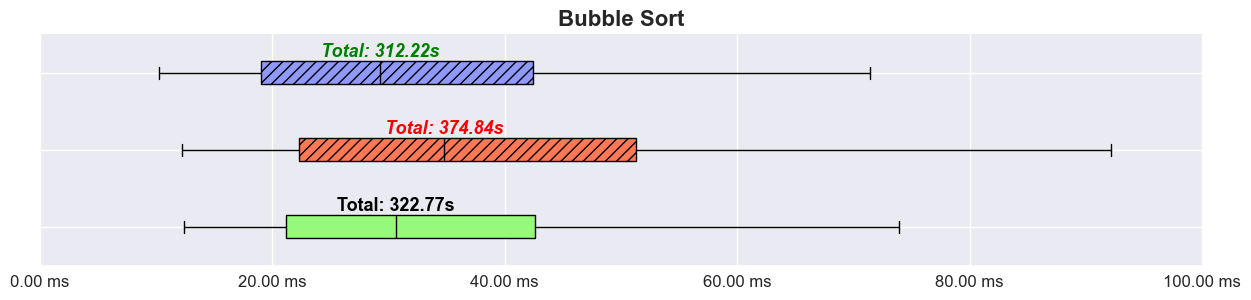

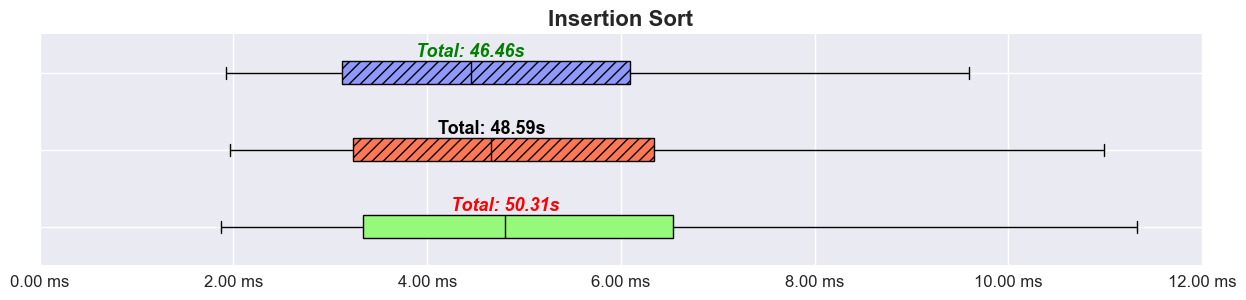

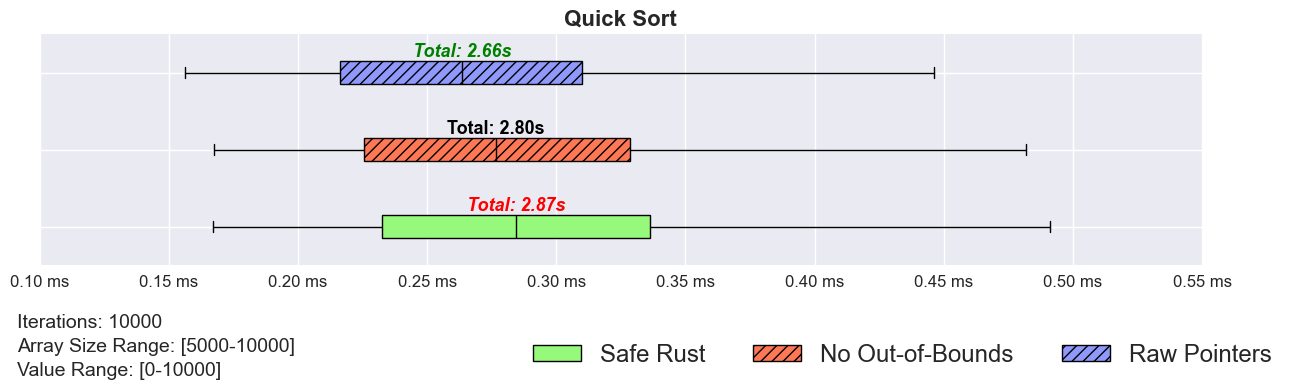

In [325]:
# GRAPH 2: Benchmarking Unsafe vs Safe Rust -- Bubble, Insertion, and Quick Sort. (Low, Mid, High)

# RUST, RUST_OOB, RUST_RAW
HEADERS = ["RUST", "RUST_OOB", "RUST_RPTR"]
SORT_TYPES = ["Bubble", "Insertion", "Quick"]

# WINDOWS:
win_us_dfs = [
    pl.read_parquet("bubble-win32_wu.parquet").select(pl.col(HEADERS)),
    pl.read_parquet("insertion-win32_wu.parquet").select(pl.col(HEADERS)),
    pl.read_parquet("quick-win32_wu.parquet").select(pl.col(HEADERS)),
]


BAR_WIDTH = 0.3

def format_time(x, pos, _ax, ns = False):
    # Seconds -> MS
    if ns:
        x *= 1e+9
        return f'{x:.0f} ns'
    else:
        x *= 1000
        return f'{x:.2f} ms'

y = 0
win_sums = [0, 0, 0]
win_lowest = [0, 0, 0]
for i, df in enumerate(win_us_dfs):
    for column in df.columns:
        if df[column].sum() > win_sums[i]:
            win_sums[i] = df[column].sum()
        if df[column].sum() <= win_lowest[i] or win_lowest[i] == 0:
            win_lowest[i] = df[column].sum()

for i,df in enumerate(win_us_dfs):
    fig, ax = plt.subplots(figsize=(15, 3))
    for j, column in enumerate(df.columns):
        plot = ax.boxplot(df.select(pl.col(column)), orientation="horizontal", patch_artist=True,
                          label=[FRIENDLY_NAMES[column]], positions=[y], widths=[BAR_WIDTH], showfliers=False)

        color = "black"
        if df[column].sum() == win_sums[i]:
            color = "red"
        elif df[column].sum() == win_lowest[i]:
            color = "green"
        total = ax.annotate("Total: %.2fs" % (df[column].sum()), xy=(df[column].median(), y+0.2),
                            fontweight="bold", fontstyle="italic" if color != "black" else "normal", color=color, fontsize=13)
        total.set_horizontalalignment("center")
        for box in plot["boxes"]:
            if not column.endswith("RUST"):
                box.set_hatch("///")
            box.set_facecolor(["xkcd:light green", "xkcd:melon", "xkcd:periwinkle blue"][j])
        for median in plot["medians"]:
            median.set_color("black")
        y += 1
    ax.set_yticklabels(["" for col in HEADERS], fontweight="bold")
    ax.set_xticks(ax.get_xticks().tolist())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_title(f"{SORT_TYPES[i]} Sort", fontweight="bold", fontsize=16)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, y, ax=ax : format_time(x, y, ax)))
    
    if i == 2:
        fig.legend(loc='lower center', bbox_to_anchor=(0.7, -0.3), ncol=3, fontsize="xx-large")
        
        fig.text(0.11, -0.1, "Iterations: 10000", dict(size=14), in_layout=False)
        fig.text(0.11, -0.18, "Array Size Range: [5000-10000]", dict(size=14), in_layout=False)
        fig.text(0.11, -0.26, "Value Range: [0-10000]", dict(size=14), in_layout=False)

    # fig.savefig(f"Figure-2-{i}.png", dpi=350, bbox_inches="tight")

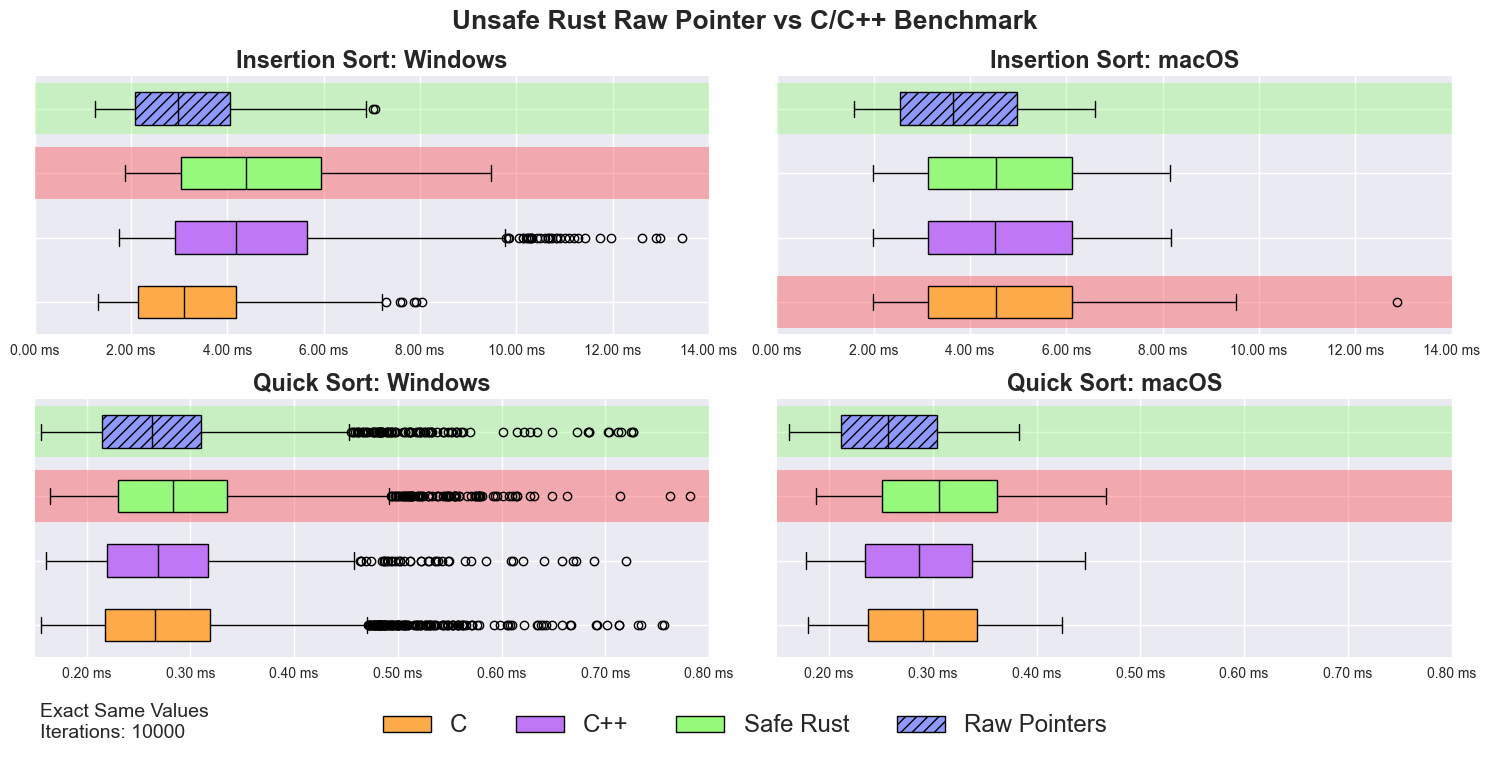

In [408]:
# GRAPH 3: RAW POINTERS (FINAL)
HEADERS = ["C", "CXX", "RUST", "RUST_RPTR"]
SORT_TYPES = ["Insertion", "Quick"]

# WINDOWS:
win_us_dfs = [
    pl.read_parquet("insertion-win32_rptr.parquet").select(pl.col(HEADERS)),
    pl.read_parquet("quick-win32_rptr.parquet").select(pl.col(HEADERS)),
]

# OSX:
darwin_us_dfs = [
    pl.read_parquet("insertion-darwin_rptr.parquet").select(pl.col(HEADERS)),
    pl.read_parquet("quick-darwin_rptr.parquet").select(pl.col(HEADERS)),
]

y = 0
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
BAR_WIDTH = 0.5

def boxplot(df, ax, platform):
    global y
    y=0

    # Finding who has the min..
    # this is so we can highlight yellow
    # we would put the total like the others, but this is a larger plot.
    _min, _minId = (None, None)
    _max, _maxId = (None, None)
    for idx, col, in enumerate(df.columns):
        _sum = df[col].sum()
        if _min == None or _sum <= _min:
            _min = _sum
            _minId = idx
        if _max == None or _sum >= _max:
            _max = _sum
            _maxId = idx

    for j, col in enumerate(df.columns):
        plot = ax.boxplot(df.select(pl.col(col)), orientation="horizontal", patch_artist=True,
                          label=["" if ax != axes[0][0] else FRIENDLY_NAMES[col]], positions=[y], widths=[BAR_WIDTH])
        for box in plot["boxes"]:
            box.set_facecolor(["xkcd:light orange", "xkcd:light purple", "xkcd:light green", "xkcd:periwinkle blue"][j])
            if col == "RUST_RPTR":
                box.set_hatch("///")
        for median in plot["medians"]:
            median.set_color("black")
        if j == _minId:
            ax.axhspan(y - 0.4, y + 0.4, facecolor="xkcd:light green", alpha=0.4)
        if j == _maxId:
            ax.axhspan(y - 0.4, y + 0.4, facecolor="xkcd:light red", alpha=0.4)
        y += 1
    ax.set_title(f"{SORT_TYPES[i]} Sort: {platform}", fontsize=17, fontweight="bold")
    if ax in (axes[0][0], axes[0][1]):
        ax.set_xlim(0, 0.014)
    else:
        ax.set_xlim(0.00015, 0.0008)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, y, ax=ax : format_time(x, y, ax)))
    ax.set_yticklabels([])

for i, df in enumerate(win_us_dfs):
    boxplot(df, axes[i][0], "Windows")

for i, df in enumerate(darwin_us_dfs):
    boxplot(df, axes[i][1], "macOS")

fig.text(0.03, -0.03, "Exact Same Values", dict(size=14), in_layout=False);
fig.text(0.03, -0.06, "Iterations: 10000", dict(size=14), in_layout=False);
fig.suptitle("Unsafe Rust Raw Pointer vs C/C++ Benchmark", fontsize=19, fontweight="bold")
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.09), ncol=4, fontsize="xx-large")
fig.tight_layout()
fig.savefig(f"Figure-3.png", dpi=350, bbox_inches="tight")

In [158]:
# GRAPH 4: SISD vs SIMD (FINAL)
df_sisd = pl.read_parquet("elementary_ops_sisd.parquet")
df_simd = pl.read_parquet("elementary_ops_simd.parquet")

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 300000.0    │
│ null_count ┆ 0.0         │
│ mean       ┆ 8823.222    │
│ std        ┆ 5969.418804 │
│ min        ┆ 5500.0      │
│ 25%        ┆ 7400.0      │
│ 50%        ┆ 8400.0      │
│ 75%        ┆ 9400.0      │
│ max        ┆ 920500.0    │
└────────────┴─────────────┘
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 300000.0    │
│ null_count ┆ 0.0         │
│ mean       ┆ 6134.714333 │
│ std        ┆ 4946.208814 │
│ min        ┆ 4200.0      │
│ 25%        ┆ 5200.0      │
│ 50%        ┆ 5800.0      │
│ 75%        ┆ 6400.0      │
│ max        ┆ 770400.0    │
└────────────┴─────────────┘


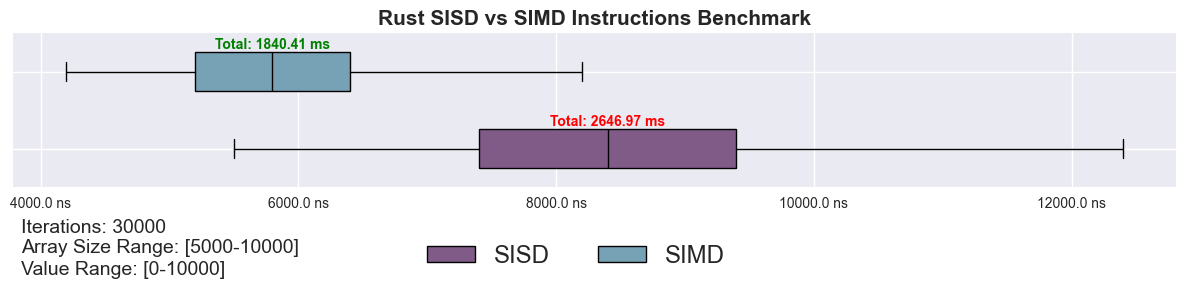

In [272]:
# GRAPH 4: SISD vs SIMD (FINAL)
fig, ax = plt.subplots(figsize=(15, 2))

# SISD:
win_plot_sisd_df = df_sisd["TIME_NS"]
win_plot = ax.boxplot(
    x=win_plot_sisd_df, positions=[1], label=["SISD"],
    orientation="horizontal", patch_artist=True, showfliers=0, widths=[0.5])
for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:muted purple")
for median in win_plot["medians"]:
    median.set_color("black")

sisd_sum = (win_plot_sisd_df.sum() / 1e+6)
sisd_total = ax.annotate("Total: %.2f ms" % sisd_sum, xy=(win_plot_sisd_df.median(), 1.3), fontweight="bold")
sisd_total.set_horizontalalignment("center")

# SIMD:
win_plot_simd_df = df_simd["TIME_NS"]
win_plot = ax.boxplot(
    x=win_plot_simd_df, positions=[2], label=["SIMD"],
    orientation="horizontal", patch_artist=True, showfliers=0, widths=[0.5])
for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:greyblue")
for median in win_plot["medians"]:
    median.set_color("black")
simd_sum = (win_plot_simd_df.sum() / 1e+6)
sisd_total.set_color("red" if simd_sum < sisd_sum else "green")
simd_total = ax.annotate("Total: %.2f ms" % simd_sum, xy=(win_plot_simd_df.median(), 2.3), fontweight="bold",
    color="red" if simd_sum > sisd_sum else "green")
simd_total.set_horizontalalignment("center")

ax.set_yticks([1, 2])
ax.set_yticklabels(["", ""], fontweight="bold", fontsize=12)
# ax.set_xlabel("Time in Nanoseconds", fontsize=14);
ax.set_title("Rust SISD vs SIMD Instructions Benchmark", fontsize=15, fontweight="bold")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f} ns"))
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fontsize="xx-large")

        
fig.text(0.13, -0.12, "Iterations: 30000", dict(size=14), in_layout=False);
fig.text(0.13, -0.22, "Array Size Range: [5000-10000]", dict(size=14), in_layout=False);
fig.text(0.13, -0.33, "Value Range: [0-10000]", dict(size=14), in_layout=False);
plt.savefig("Figure_4.png", dpi=350, bbox_inches="tight")

print(win_plot_sisd_df.describe())
print(win_plot_simd_df.describe())